**Predicting phenotypic states from single cell analysis**

excerpt: Using logistic regression to classify the activation state of a neuron from gene expression using Python and sci-kit learn.
header:
  image: /assets/cellstate/nerve-cell-2213009_1280.jpg
  teaser: /assets/cellstate/nerve-cell-2213009_1280.jpg

[Single-cell analysis](https://en.wikipedia.org/wiki/Single-cell_analysis) has revolutionized biological studies by providing greater resolution to tissue profiling and allowing for rare cell characterization. By far, the most popular application of single-cell analysis is transcriptional profiling of cells; that is, determining what cellular [mRNA](https://en.wikipedia.org/wiki/Messenger_RNA) is being expressed. I've been fortunate to have the opportunity to contribute to this field from my [academic](https://www.nature.com/articles/ncomms11022) and [industry](https://www.fluidigm.com/applications/single-cell-analysis) work.

For some single-cell approaches, it is possible to link phenotypic information about the cell with the thousands of genes that a cell can express. For example, a certain phenotype could be indicated by expression of a known marker [protein](https://en.wikipedia.org/wiki/Protein). The protein's expression can be assessed by [flow sorting](https://en.wikipedia.org/wiki/Flow_cytometry) or cellular imaging with [fluorescence microscopy](https://en.wikipedia.org/wiki/Fluorescence_microscope) upstream of processing for single-cell transcriptome expression. However, it can be labor-intensive or not always possible to phenotype the cell, especially as current experiments scale to [thousands](https://www.nature.com/articles/ncomms14049) of single-cell samples. 

In this project, I am interested in exploring the possibility of using machine learning to train an algorithm towards identifying cellular phenotype based on gene expression alone. I'll use one set of data that we analyzed in my [academic work](https://www.nature.com/articles/ncomms11022). In our study, we looked in the mouse brain and characterized neurons activated by a novel experience. A commonly used phenotype of an activated neuron is whether it expresses the gene Fos (otherwise known as [c-Fos](https://en.wikipedia.org/wiki/C-Fos)).

This dataset begins with 96 samples of which 48 were Fos+ and 48 were Fos-, but as you'll see, filtering steps were applied to reduce the number of samples. The number of genes starts off with over 43,000(!) but as you see, this also gets reduced with filtering. I then use the unsupervised algorithm of PCA to see how whether activated and non-activated subpopulations separate  following dimensional reduction. Finally, I use logistic regression to train a subset of neurons for classification based on Fos state, then assess the accuracy of the model on a cross-validation subset.

In [3]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import data

In [4]:
# Import gene expression data frame
parent_path = '/Users/lacar/Documents/Gage lab/Gage Lab Dropbox/CellIsolation_MethodsPaper/PaperAndFigs/FromOneDrive_finalDocuments/Lab/AnalysisOfSequencing'
child_path = '/SaraRSEM_output/update15_0225/'
os.chdir(parent_path + child_path)
df_tpm = pd.read_table('RSEM_geneSymbol_tpm_141204_allsamples.txt', sep=' ').transpose()

In [5]:
# The genes are the columns (features) of the dataframe,
# while each single-cell sample are the row indexes.
# The values are the expression level of that gene for that sample.
df_tpm.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,22.39,0.0,0.0,0.00,0.0,0.00,0.0,22.03,0.00
nc_ui_ti_C11_141204,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,69.07,0.00
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.0,0.0,173.27,0.0,0.0,...,0.0,2905.22,0.0,0.0,0.00,0.0,0.00,0.0,0.00,5.87
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.0,0.0,0.00,2.3,0.0,...,0.0,156.51,0.0,0.0,2.91,0.0,200.94,0.0,62.27,0.00
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,2.99,0.00


## Data filtering

### Apply a gene filter

In [6]:
# Filter the dataframe by removing genes that are not expressed in any cell
genes_retained_mask = df_tpm.sum(axis=0)>0
df_tpm2 = df_tpm[genes_retained_mask.index[genes_retained_mask]]
df_tpm2.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,22.39,0.0,0.0,0.00,0.00,0.0,22.03,0.00
nc_ui_ti_C11_141204,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,69.07,0.00
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.0,0.0,173.27,0.0,0.0,...,0.0,0.0,2905.22,0.0,0.0,0.00,0.00,0.0,0.00,5.87
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.0,0.0,0.00,2.3,0.0,...,0.0,0.0,156.51,0.0,0.0,2.91,200.94,0.0,62.27,0.00
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,2.99,0.00


### Apply a sample filter
Start by exploring the distribution of gene counts for each sample

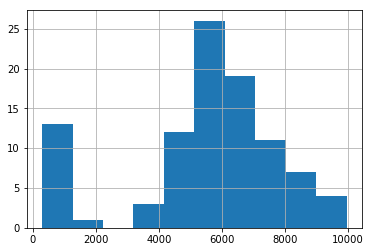

In [7]:
# Filter the dataframe by removing samples with low gene count
df_tpm2[df_tpm2 > 1].count(axis=1).hist();

Removing samples that have less than 3000 genes seems like a logical cutoff.

In [8]:
# Filter the dataframe by removing samples with low gene count (3000 genes)
samples_retained_mask = df_tpm2[df_tpm2 > 1].count(axis=1) > 3000

In [9]:
df_tpm3 = df_tpm2[samples_retained_mask]

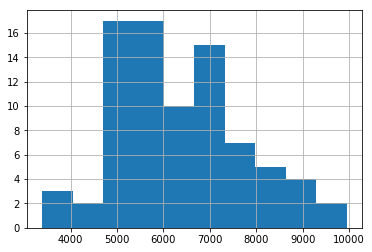

In [10]:
# Sanity check that appropriate filter is implemented
df_tpm3[df_tpm3 > 1].count(axis=1).hist();

In [11]:
# Create a vector containing the fos label
df_tpm3['SampleName'] = df_tpm3.index  # temporarily create a sample name vector
df_tpm3.loc[:,'fos_label'] = df_tpm3['SampleName'].str.split('_', expand=True)[2]
df_tpm3.drop('SampleName', axis=1, inplace=True)

/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [12]:
df_tpm3.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,fos_label
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.00,22.39,0.0,0.0,0.00,0.00,0.00,22.03,0.00,ti
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.00,0.0,173.27,0.0,0.0,...,0.00,2905.22,0.0,0.0,0.00,0.00,0.00,0.00,5.87,ti
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.00,0.0,0.00,2.3,0.0,...,0.00,156.51,0.0,0.0,2.91,200.94,0.00,62.27,0.00,ti
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,2.99,0.00,ti
nc_ui_ti_C9_141204,10.13,5.22,0.0,0.0,0.0,2.26,0.0,0.00,0.0,0.0,...,5.87,1045.78,0.0,0.0,0.00,2.41,421.23,113.95,0.00,ti


In [13]:
# Replace labels with 0 and 1 for classification
df_tpm3['fos_label'].replace(to_replace='ti', value=1, inplace=True)
df_tpm3['fos_label'].replace(to_replace='tn', value=0, inplace=True)

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [14]:
# Show the number of examples for each group. Note that 1 = FOS+, 0 = FOS-.
df_tpm3.groupby('fos_label')['fos_label'].count()

fos_label
0    43
1    39
Name: fos_label, dtype: int64

## PCA visualization

Visualize how the groups would separate without using the label. 

In [15]:
X = df_tpm3.loc[:,:'Zzz3']

In [16]:
# Run PCA, ignoring the label
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
# X1 = pca.fit(X).transform(X)

In [17]:
# Add PCA vectors to dataframe
df_tpm3.loc[:,'PCAx'] = X[:,0]
df_tpm3.loc[:,'PCAy'] = X[:,1]

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
df_tpm3.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,fos_label,PCAx,PCAy
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,22.03,0.00,1,55265.247009,-2057.597830
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.00,0.0,173.27,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,5.87,1,25373.311476,-2100.477988
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.00,0.0,0.00,2.3,0.0,...,0.0,0.0,2.91,200.94,0.00,62.27,0.00,1,66632.262116,-1961.555875
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,2.99,0.00,1,83235.237261,-1817.245181
nc_ui_ti_C9_141204,10.13,5.22,0.0,0.0,0.0,2.26,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,2.41,421.23,113.95,0.00,1,54599.738613,-681.069431


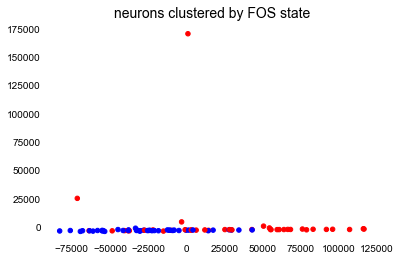

In [19]:
# PCA, colored by ethnicities
f, ax1 = plt.subplots(1,1)
cmap = 'bwr'

points = ax1.scatter(df_tpm3['PCAx'], df_tpm3['PCAy'], c=df_tpm3['fos_label'], s=20, cmap=cmap)

# plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('')
ax1.set_title('neurons clustered by FOS state', size=14)
#ax1.set_ylim(-4000,0)
#ax1.legend(loc=0, title='FOS state')
    
# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame


Yikes, this is not the prettiest plot. I spent time figuring out if I had done something wrong, even going back to Andrew Ng's lecture on PCA. I eventually figured out that I forgot to transform the feature values so that they're not spread out across so many different scales. Log2 normalization is common in the single-cell field. It's also clear that there are some outliers here. I'll take care of both of these modifications in the next bit of code.

In [20]:
# Filter the samples that are obvious outliers
df_tpm4 = df_tpm3[df_tpm3['PCAy'] < 25000]

In [21]:
# Use new dataframe and log transform so features are not spread across different scales
X = df_tpm4.loc[:,:'Zzz3']
X = np.log2(X+1)  # the +1 is added to deal with the log transformation

In [22]:
# Run PCA again
pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

In [23]:
# Add new PCA vectors to dataframe
df_tpm4.loc[:,'PCAx'] = X[:,0]
df_tpm4.loc[:,'PCAy'] = X[:,1]

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
df_tpm4.shape

(80, 24348)

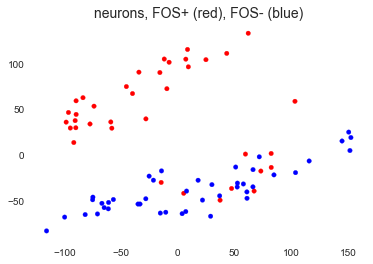

In [25]:
# PCA, colored by FOS state

f, ax1 = plt.subplots(1,1)
cmap = 'bwr'

points = ax1.scatter(df_tpm4['PCAx'], df_tpm4['PCAy'], c=df_tpm4['fos_label'], s=20, cmap=cmap)

# plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('')
ax1.set_title('neurons, FOS+ (red), FOS- (blue)', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame


There we go. With the exception of a few FOS+ neurons, the groups separate quite nicely as we showed in the paper. The FOS+ neurons that are amongst the FOS- neurons are discussed further in our paper (we call them pseudo-FOS+ neurons), but for the purposes of this project, I will remove them from further analysis.

In [26]:
# Filtered dataframe by removing pseudo-FOS+ neurons.
mask = (df_tpm4['fos_label']==1) & (df_tpm4['PCAy'] < 0)
df_tpm5 = df_tpm4[~mask]   # use ~ to get the inverse of what the mask is getting

In [27]:
# Group sizes moving forward
df_tpm5.groupby('fos_label')['fos_label'].count()

fos_label
0    43
1    30
Name: fos_label, dtype: int64

In [28]:
df_tpm5.shape

(73, 24348)

In [29]:
df_tpm5.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,fos_label,PCAx,PCAy
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,22.03,0.00,1,-98.443404,35.573904
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.00,0.0,173.27,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,5.87,1,-89.695337,58.957000
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.00,0.0,0.00,2.3,0.0,...,0.0,0.0,2.91,200.94,0.00,62.27,0.00,1,-73.877361,53.059502
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,2.99,0.00,1,-89.654077,44.035686
nc_ui_ti_C9_141204,10.13,5.22,0.0,0.0,0.0,2.26,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,2.41,421.23,113.95,0.00,1,-77.416770,33.563082


In [30]:
X = np.log2(df_tpm5.loc[:,:'Zzz3']+1)   # a matrix
%store X

Stored 'X' (DataFrame)


In [31]:
y = df_tpm5['fos_label']  # a vector
%store y

Stored 'y' (Series)


## Supervised machine learning

What machine learning algorithm should I apply? This is a classification problem (FOS+ vs. FOS-) but this is also a situation where the number of *m* examples (73) is much, much smaller than the number of *n* features?  << n features (24345)?

I reviewed my notes from the [Machine Learning course](https://www.coursera.org/learn/machine-learning) I completed and saw that logistic regression or support vector machines without a kernel ("linear") would be good options. Andrew Ng talks about this [here](https://youtu.be/FCUBwP-JTsA?t=867).

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/Users/lacar/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
# I didn't carry over the log2 normalization, so I'll do it again here.
# Using X and y to refer to my feature set and label set, respectively

X = np.log2(df_tpm5.loc[:,:'Zzz3']+1)   # a matrix
y = df_tpm5['fos_label']  # a vector

### Using all samples for training and testing

This is a first pass at trying the data on this model.

In [33]:
# Followed DataSchool example found online
# (http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976)

# Instantiate a logistic regression model, and fit with X and y 
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

1.0

A perfect accuracy, which is awesome, but not entirely surprising for two reasons. We used all of the samples for both training and testing and we saw that PCA split these two groups pretty cleanly. Nevertheless, let's see how the model coefficients look.

In [34]:
# Examining the model coefficients
df_gene_model_coef = pd.DataFrame()
df_gene_model_coef['gene'] = X.columns
df_gene_model_coef['coef'] = np.transpose(model.coef_)
df_gene_model_coef.sort_values(by='coef', ascending=False).head(5)

,gene,coef
2020,Arc,0.012490
17392,Plk2,0.011933
1875,Ankrd33b,0.011126
16864,Pcdh8,0.010876
13538,Ifrd1,0.010867


While the coefficients are not very high, the top gene is Arc, a immediate early gene known for being involved in activity. This is encouraging for our model since it matches what we predict and also what we've shown through differential expression, which is shown in the paper.

### Evaluation by splitting into training and validation sets

In [35]:
# Split into train and test sets. I'll use a ratio of 60/40 of train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Sanity check by evaluating train and test samples and shape

In [36]:
X_train.head(10)

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
nc_ux_tn_A6_141204,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,9.227905,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,6.257199,0.000000,0.000000,0.000000,6.616475
nc_ui_ti_C8_141204,0.000000,6.443607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.996389,0.000000
nm_ux_ti_F12_141204,3.693766,4.218781,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,10.052269,0.0,0.0,0.000000,1.847997,0.000000,3.344828,0.000000
nc_ui_tn_C1_141204,0.000000,9.720073,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.705978,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,7.086189,3.379898,0.000000
nc_ux_tn_B1_141204,0.000000,8.137811,0.0,0.0,9.276031,6.100978,0.000000,0.000000,0.000000,0.000000,...,3.906891,0.000000,0.000000,0.0,0.0,0.000000,5.612058,0.000000,7.188440,0.000000
nm_ux_ti_F9_141204,1.169925,3.865919,0.0,0.0,0.000000,6.123708,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.506367,0.0,0.0,0.000000,4.922198,0.992768,4.292782,0.000000
nm_ui_tn_H5_141204,3.580145,9.489045,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.070389,0.000000,...,0.000000,0.000000,9.886215,0.0,0.0,0.000000,0.000000,0.000000,6.649759,0.000000
nm_ux_tn_E1_141204,2.160275,5.434962,0.0,0.0,0.000000,0.000000,4.426936,0.000000,3.240314,8.639702,...,6.805163,0.000000,7.471756,0.0,0.0,0.000000,2.912650,0.000000,5.597829,7.555816
nc_ux_tn_B2_141204,0.000000,5.245648,0.0,0.0,0.000000,5.044831,0.000000,0.000000,1.985500,0.000000,...,0.000000,2.446256,9.375735,0.0,0.0,6.007196,5.561937,3.910733,3.897240,7.298017
nc_ui_tn_C6_141204,0.000000,5.305606,0.0,0.0,0.000000,3.711495,0.000000,0.000000,0.000000,0.000000,...,0.000000,11.446024,3.165108,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
print('training set shape: ', X_train.shape, 'test set shape: ', X_test.shape)

training set shape:  (43, 24345) test set shape:  (30, 24345)


#### Run predictions!

In [38]:
# Predict fos labels for the test set
predicted = model2.predict(X_test)
print(predicted)

[0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0]


In [39]:
# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[  9.79129870e-01,   2.08701297e-02],
       [  9.27710561e-04,   9.99072289e-01],
       [  2.52824449e-03,   9.97471756e-01],
       [  9.90136982e-01,   9.86301831e-03],
       [  9.94536631e-01,   5.46336891e-03],
       [  9.96892526e-01,   3.10747429e-03],
       [  9.96896054e-01,   3.10394595e-03],
       [  9.93028840e-01,   6.97116028e-03],
       [  9.98386314e-01,   1.61368561e-03],
       [  8.44309409e-01,   1.55690591e-01],
       [  4.00968687e-03,   9.95990313e-01],
       [  6.90008585e-03,   9.93099914e-01],
       [  7.28804895e-03,   9.92711951e-01],
       [  1.54732724e-03,   9.98452673e-01],
       [  9.90972984e-01,   9.02701592e-03],
       [  9.96487663e-01,   3.51233658e-03],
       [  9.97721457e-01,   2.27854258e-03],
       [  9.95794236e-01,   4.20576436e-03],
       [  7.64663538e-04,   9.99235336e-01],
       [  9.35144305e-01,   6.48556948e-02],
       [  3.57385183e-02,   9.64261482e-01],
       [  7.93948287e-01,   2.06051713e-01],
       [  

In [40]:
# generate evaluation metrics
print('Accuracy score: ', metrics.accuracy_score(y_test, predicted))
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy score:  0.966666666667
ROC AUC:  0.99537037037


In [41]:
metrics.confusion_matrix(y_test, predicted, labels=[1, 0])

array([[11,  1],
       [ 0, 18]])

In [42]:
print('Confusion matrix: \n',
      'TP', 'FN\n', 'FP', 'TN\n',
      metrics.confusion_matrix(y_test, predicted, labels=[1, 0]))

Confusion matrix: 
 TP FN
 FP TN
 [[11  1]
 [ 0 18]]


In [43]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97        18
          1       1.00      0.92      0.96        12

avg / total       0.97      0.97      0.97        30



Therefore, all 18 FOS- neurons were predicted correctly while 11 of the 12 FOS+ neurons were predicted correctly. You can see the actual sample that was missed in the table below.

In [44]:
pd.DataFrame({'actual': y_test, 'predicted': predicted})

,actual,predicted
nm_ui_tn_H3_141204,0,0
nm_ux_ti_E10_141204,1,1
nc_ux_ti_A7_141204,1,1
nm_ui_tn_G1_141204,0,0
nc_ux_tn_A4_141204,0,0
nc_ux_tn_A2_141204,0,0
nm_ux_tn_F4_141204,0,0
nm_ui_tn_H4_141204,0,0
nc_ux_tn_B4_141204,0,0
nc_ui_ti_D7_141204,1,0


## Summary

The goal of this classification project was to determine if we could train an algorithm to predict cellular phenotype based on gene expression. Using a previously published dataset based on activated neurons, I establish proof-of-principle that this is possible. Application of logistic regression leads to an accuracy score of 96.7%, which was just one actual FOS+ neuron falsely called as FOS-. This is pretty good when looking at two different cellular states for this sample size. Possible next steps are to try a different classification algorithm (like SVM) to try and get perfect accuracy, scale up and do more samples, and/or do more cellular phenotypes. Ultimately, this approach has the potential to enhance the value of single-cell applications, by providing phenotypic information in experiments where it would difficult or impossible to experimentally assess.